# Components

In [1]:
import pandas as pd
import numpy as np
import csv
import json
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
reader = csv.reader(open("components/undefined-components.csv"))
next(reader, None)
undefined_components = {}
for row in reader: undefined_components[row[0]] = row[1] 

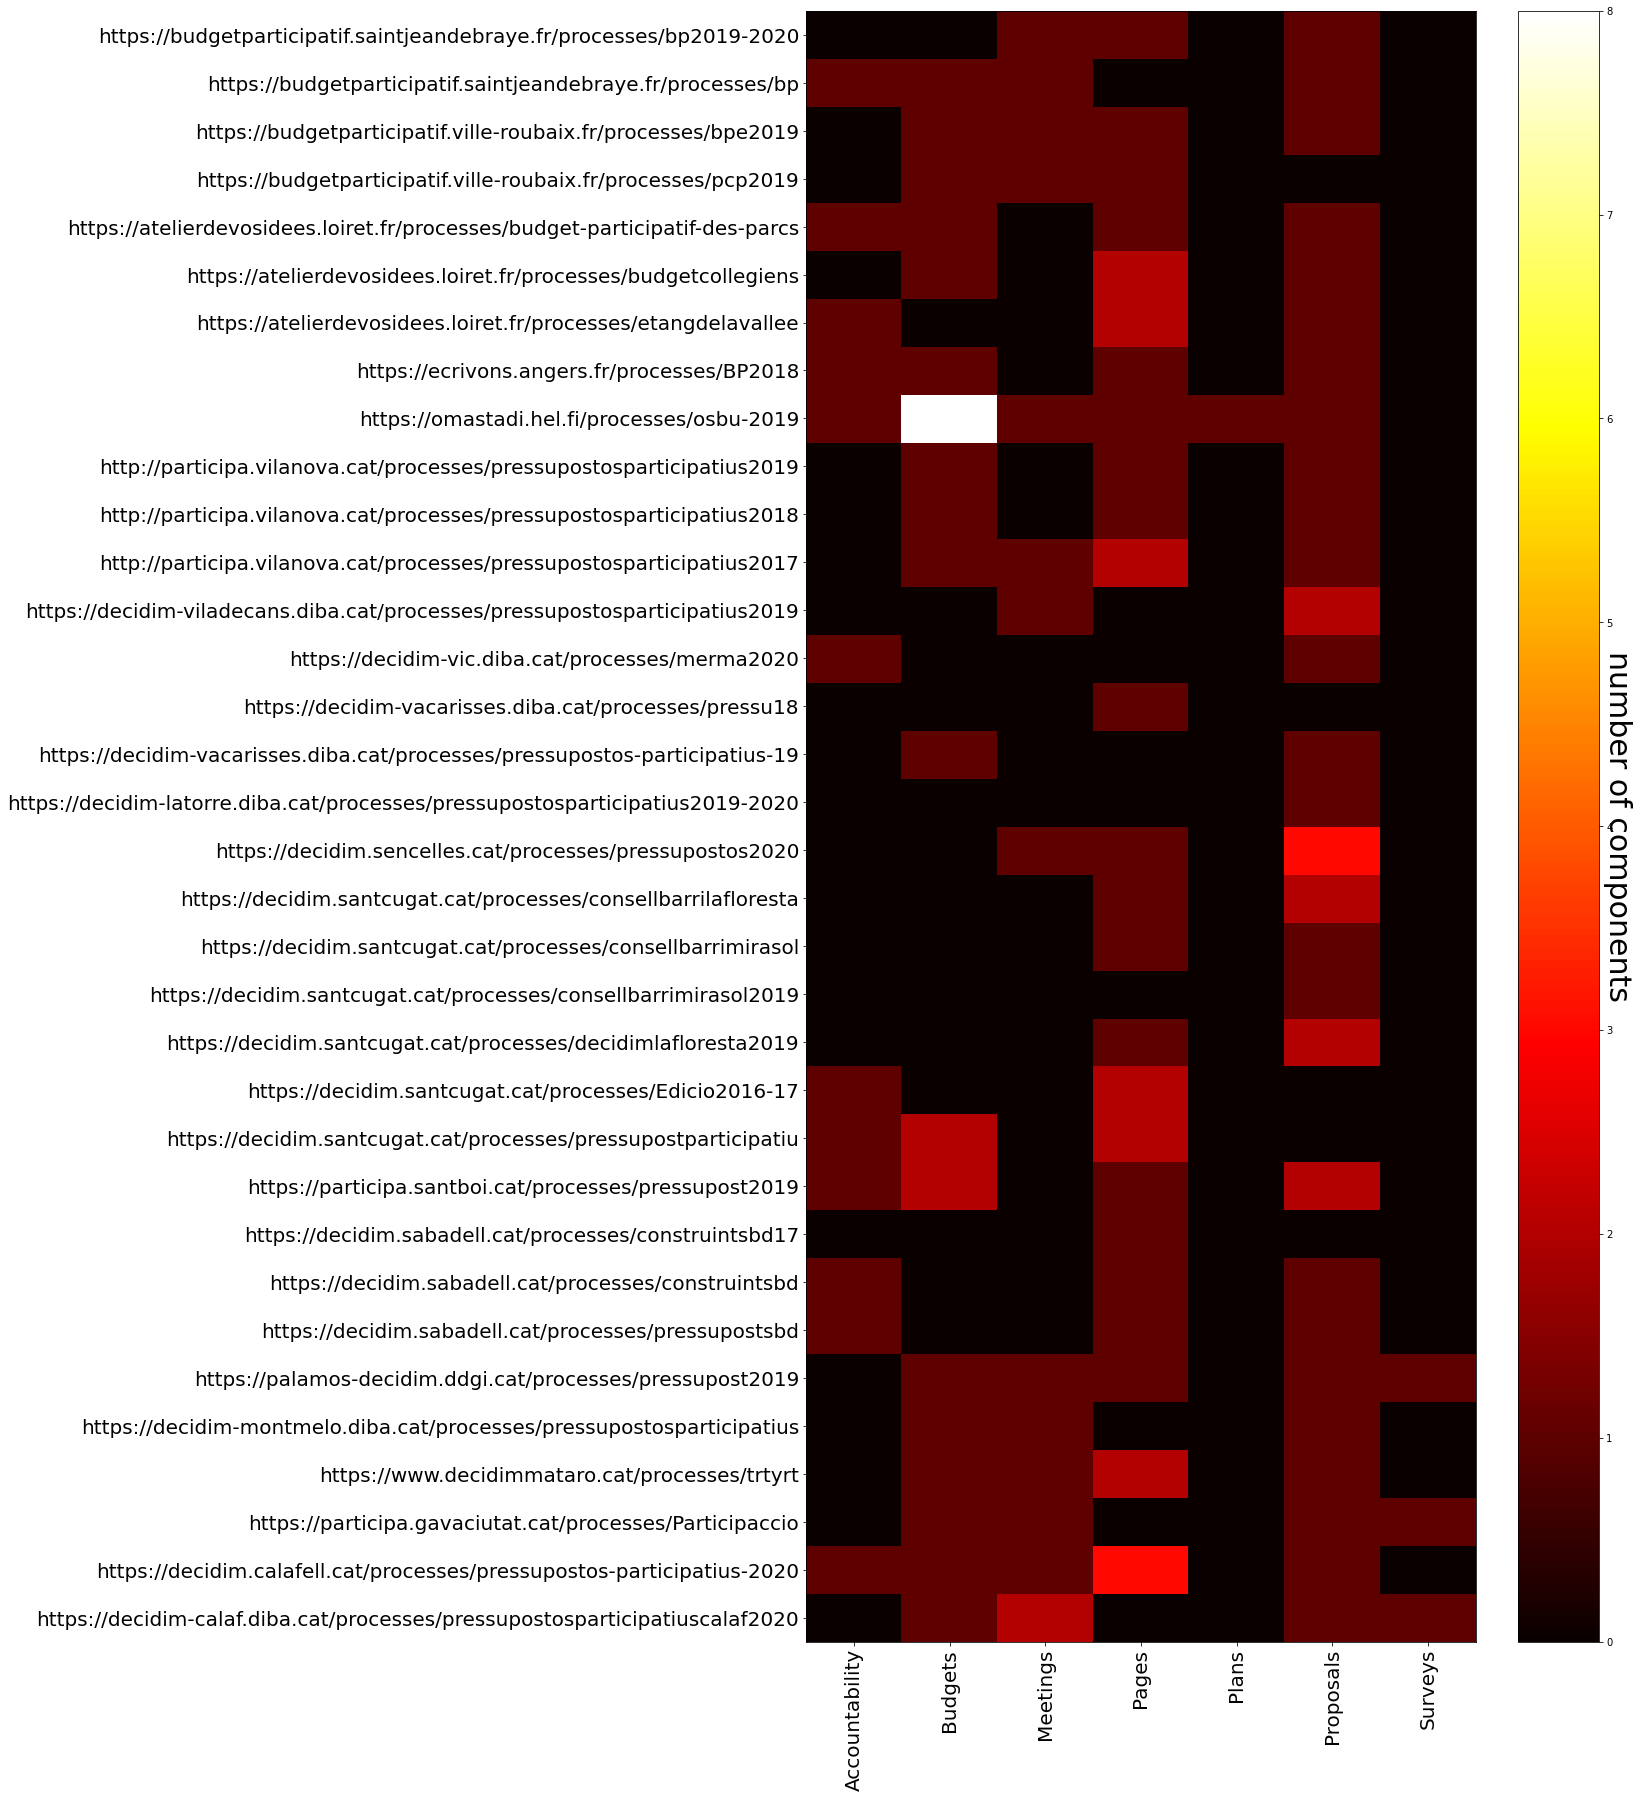

In [3]:
df = pd.read_csv('decidimpb.csv',sep='\t')
processes = df[['PB process url','PB process id']].values

decidim_components = ['Accountability','Budgets','Meetings','Pages','Plans','Proposals','Surveys']
instances_components = {}

for process in processes:
    id = str(int(process[1]))
    host = process[0].split('/processes/')[0]
    process_name = process[0].split('/processes/')[1]
    parsed_uri = urlparse(host)
    try:
        with open('processes/'+ '{uri.netloc}'.format(uri=parsed_uri).replace('.','_')+'__'+process_name+'.json') as json_file:
            data = json.load(json_file)
            process_components = (data['data']['participatoryProcess']['components'])
            for component in decidim_components: 
                instances_components[(process[0],component)] = 0
            for component in process_components: 
                typename = component['__typename']
                if 'Component'== typename:
                    typename = undefined_components[process[0]+'/f/'+component['id']]

                if typename != '':
                    instances_components[(process[0],typename)] = instances_components[(process[0],typename)]+1
    except:
        print('error','processes/'+ '{uri.netloc}'.format(uri=parsed_uri).replace('.','_')+'__'+process_name+'.json')
        


with open('components/components.csv', mode='w') as component_file:
    component_writer = csv.writer(component_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    component_writer.writerow(['process']+decidim_components)        
    for process in processes:        
            try:
                component_writer.writerow(
                    [process[0]] + [instances_components[(process[0],component)] for component in decidim_components])
            except:
                pass
            
        
df = pd.read_csv('components/components.csv', index_col=[0])
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
heatmap = ax.pcolor(df.values, cmap=plt.cm.hot)
fig.set_size_inches(15, 30)
ax.set_xticks(np.arange(len(decidim_components)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(df.index.values.tolist())) + 0.5, minor=False)
ax.set_yticklabels(df.index.values.tolist())
ax.set_xticklabels(decidim_components)
plt.xticks(rotation=90)
cbar = plt.colorbar(heatmap)
cbar.set_label('number of components', rotation=270, labelpad=20, fontsize=30)    
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
plt.show()
#fig.savefig('img/heatmap_lang_country.pdf', format='pdf')                    

<AxesSubplot:>

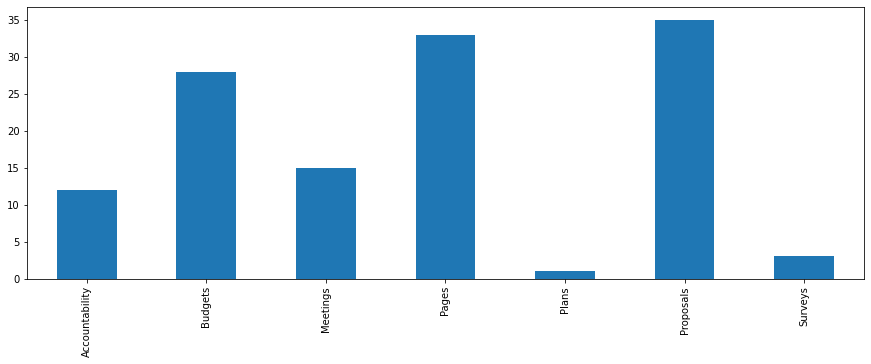

In [4]:
df.sum(axis=0).plot(kind="bar", figsize=(15,5))

<AxesSubplot:xlabel='process'>

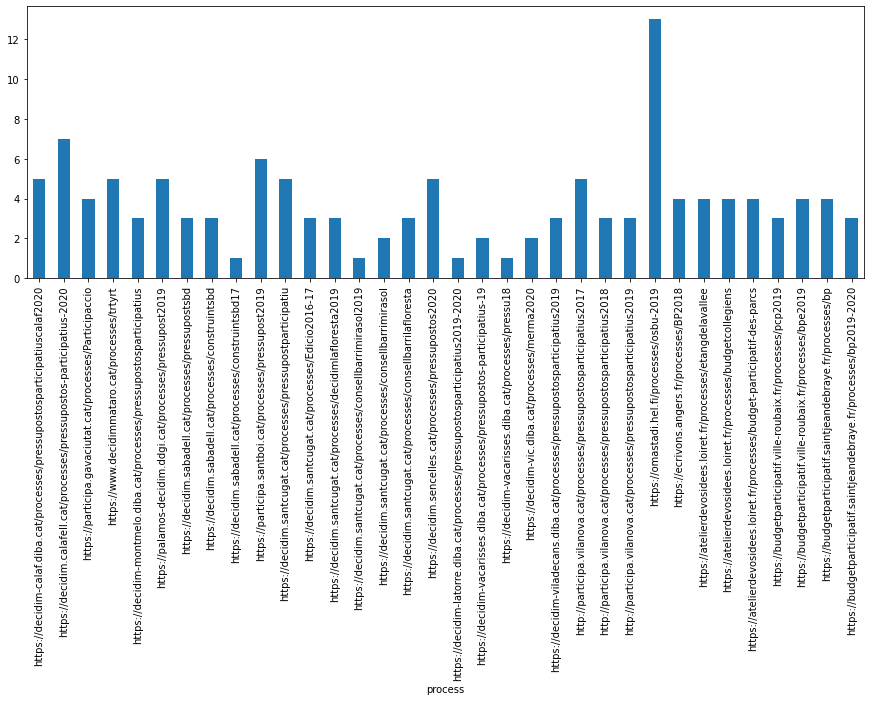

In [5]:
df.sum(axis=1).plot(kind="bar", figsize=(15,5))

In [6]:
correlation = df.corr()
correlation.style.background_gradient(cmap='coolwarm')

,Accountability,Budgets,Meetings,Pages,Plans,Proposals,Surveys
Accountability,1.000000,0.272434,-0.255508,0.276263,0.235702,-0.134814,-0.229752
Budgets,0.272434,1.000000,0.255989,0.080444,0.903927,-0.062831,0.039722
Meetings,-0.255508,0.255989,1.000000,-0.111073,0.176039,0.134329,0.502241
Pages,0.276263,0.080444,-0.111073,1.000000,0.006854,-0.189375,-0.265395
Plans,0.235702,0.903927,0.176039,0.006854,1.000000,-0.008289,-0.054153
Proposals,-0.134814,-0.062831,0.134329,-0.189375,-0.008289,1.000000,-0.014814
Surveys,-0.229752,0.039722,0.502241,-0.265395,-0.054153,-0.014814,1.000000


# Clustering

In [7]:
std = StandardScaler().fit_transform(df) # normalizing the data 
pca = PCA(n_components=len(decidim_components))
principalComponents = pca.fit_transform(std)

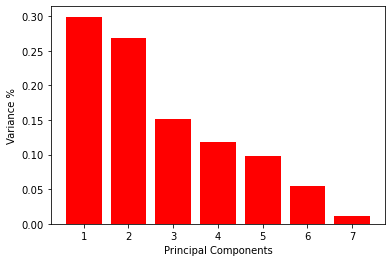

In [8]:
# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='red')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

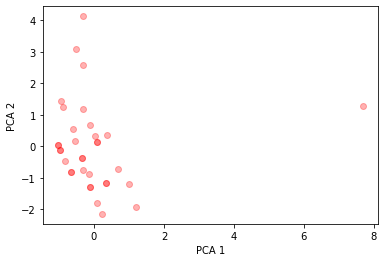

In [9]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

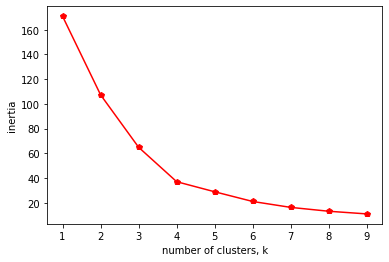

In [10]:
inertias = []

# Creating 10 K-Mean models while varying the number of clusters (k)
for k in range(1,10):
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(range(1,10), inertias, '-p', color='red')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

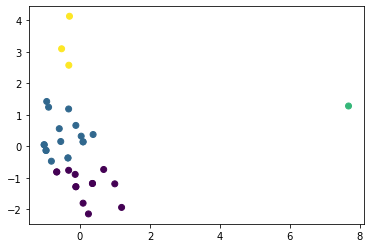

In [11]:
n_clusters=4
model = KMeans(n_clusters)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

In [12]:
process_names = df.index.values.tolist()
for c in range(n_clusters):
    print('\nCluster',c)
    indices = list(np.where(labels == c)[0])
    for i in indices:
        print(process_names[i])


Cluster 0
https://decidim.calafell.cat/processes/pressupostos-participatius-2020
https://decidim.sabadell.cat/processes/pressupostsbd
https://decidim.sabadell.cat/processes/construintsbd
https://decidim.sabadell.cat/processes/construintsbd17
https://participa.santboi.cat/processes/pressupost2019
https://decidim.santcugat.cat/processes/pressupostparticipatiu
https://decidim.santcugat.cat/processes/Edicio2016-17
https://decidim-vacarisses.diba.cat/processes/pressu18
https://decidim-vic.diba.cat/processes/merma2020
https://ecrivons.angers.fr/processes/BP2018
https://atelierdevosidees.loiret.fr/processes/etangdelavallee
https://atelierdevosidees.loiret.fr/processes/budgetcollegiens
https://atelierdevosidees.loiret.fr/processes/budget-participatif-des-parcs

Cluster 1
https://www.decidimmataro.cat/processes/trtyrt
https://decidim-montmelo.diba.cat/processes/pressupostosparticipatius
https://decidim.santcugat.cat/processes/decidimlafloresta2019
https://decidim.santcugat.cat/processes/consel

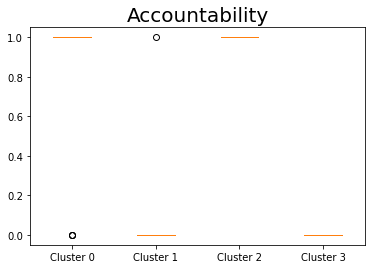

Cluster 0 [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Cluster 1 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Cluster 2 [1]
Cluster 3 [0, 0, 0]





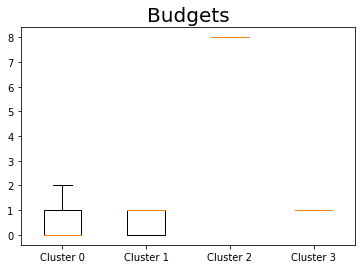

Cluster 0 [1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1]
Cluster 1 [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0]
Cluster 2 [8]
Cluster 3 [1, 1, 1]





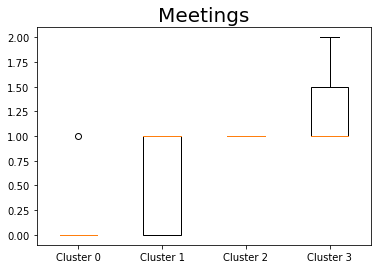

Cluster 0 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 1 [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]
Cluster 2 [1]
Cluster 3 [2, 1, 1]





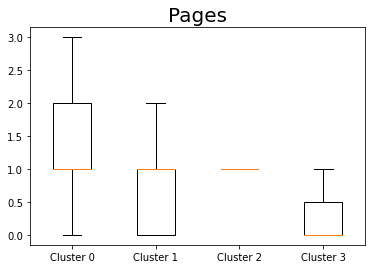

Cluster 0 [3, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 1]
Cluster 1 [2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 1]
Cluster 2 [1]
Cluster 3 [0, 0, 1]





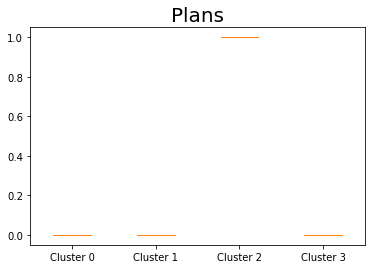

Cluster 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 1 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 2 [1]
Cluster 3 [0, 0, 0]





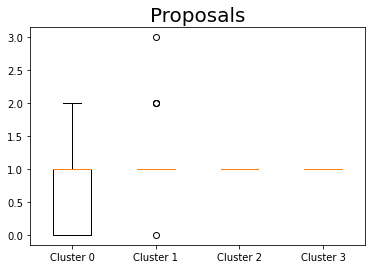

Cluster 0 [1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1]
Cluster 1 [1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1]
Cluster 2 [1]
Cluster 3 [1, 1, 1]





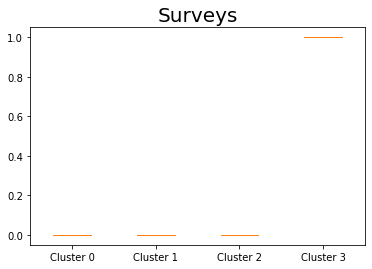

Cluster 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 1 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 2 [0]
Cluster 3 [1, 1, 1]





In [13]:
for component in decidim_components:
    data = []
    process_components = df[component].values.tolist()
    for c in range(n_clusters):
        values = [process_components[i] for i in list(np.where(labels == c)[0])]
        data.append(values)
    fig, ax = plt.subplots()
    ax.set_title(component, fontsize=20)
    box = ax.boxplot(data, patch_artist=True)
    plt.setp(box["boxes"], facecolor='white')
    ax.set_xticklabels(['Cluster '+str(i) for i in range(n_clusters)])
    plt.show()
    for i, d in enumerate(data):
        print ('Cluster',i,d)
    print ('\n\n')

# Clustering without Omastadi

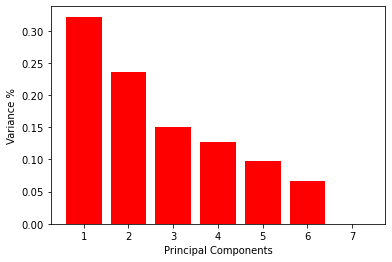

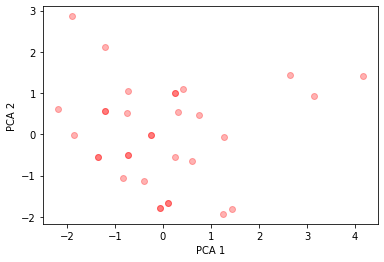

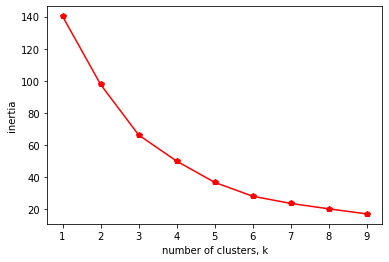

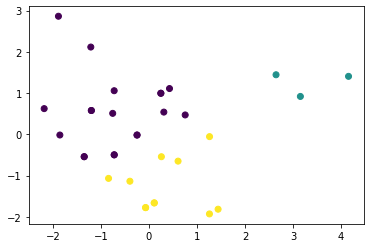


Cluster 0
https://decidim.calafell.cat/processes/pressupostos-participatius-2020
https://www.decidimmataro.cat/processes/trtyrt
https://decidim.sabadell.cat/processes/pressupostsbd
https://decidim.sabadell.cat/processes/construintsbd
https://decidim.sabadell.cat/processes/construintsbd17
https://participa.santboi.cat/processes/pressupost2019
https://decidim.santcugat.cat/processes/pressupostparticipatiu
https://decidim.santcugat.cat/processes/Edicio2016-17
https://decidim-vacarisses.diba.cat/processes/pressu18
http://participa.vilanova.cat/processes/pressupostosparticipatius2017
http://participa.vilanova.cat/processes/pressupostosparticipatius2018
http://participa.vilanova.cat/processes/pressupostosparticipatius2019
https://omastadi.hel.fi/processes/osbu-2019
https://ecrivons.angers.fr/processes/BP2018
https://atelierdevosidees.loiret.fr/processes/etangdelavallee
https://atelierdevosidees.loiret.fr/processes/budgetcollegiens
https://atelierdevosidees.loiret.fr/processes/budget-partici

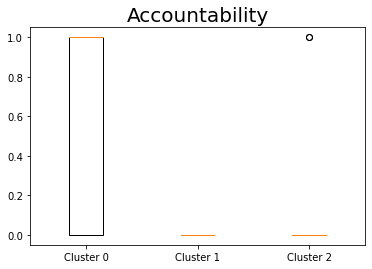

Cluster 0 [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]
Cluster 1 [0, 0, 0]
Cluster 2 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]





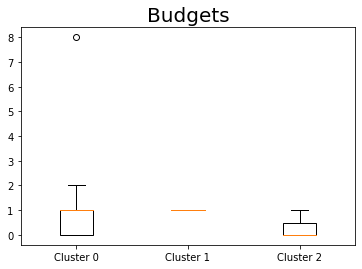

Cluster 0 [1, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 8, 1, 0, 1, 1, 1, 1]
Cluster 1 [1, 1, 1]
Cluster 2 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]





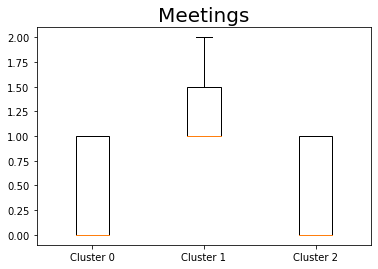

Cluster 0 [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]
Cluster 1 [2, 1, 1]
Cluster 2 [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]





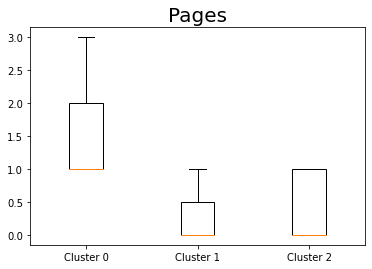

Cluster 0 [3, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1]
Cluster 1 [0, 0, 1]
Cluster 2 [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]





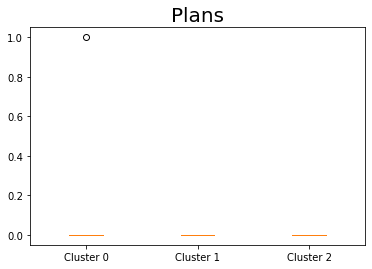

Cluster 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Cluster 1 [0, 0, 0]
Cluster 2 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]





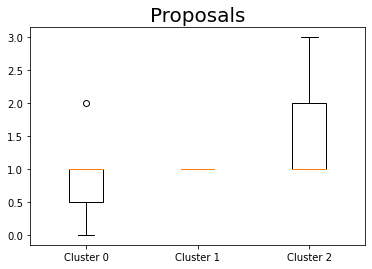

Cluster 0 [1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Cluster 1 [1, 1, 1]
Cluster 2 [1, 2, 1, 1, 2, 3, 1, 1, 1, 2, 1]





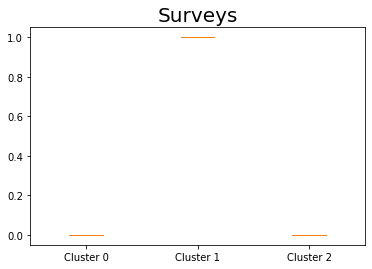

Cluster 0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Cluster 1 [1, 1, 1]
Cluster 2 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]





In [14]:
std = StandardScaler().fit_transform(df.drop([
    'https://omastadi.hel.fi/processes/osbu-2019'
]))
pca = PCA(n_components=len(decidim_components))
principalComponents = pca.fit_transform(std)

# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='red')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)
plt.show()

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)

plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

inertias = []

# Creating 10 K-Mean models while varying the number of clusters (k)
for k in range(1,10):
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(range(1,10), inertias, '-p', color='red')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

n_clusters=3
model = KMeans(n_clusters)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

process_names = df.index.values.tolist()
for c in range(n_clusters):
    print('\nCluster',c)
    indices = list(np.where(labels == c)[0])
    for i in indices:
        print(process_names[i])
        
for component in decidim_components:
    data = []
    process_components = df[component].values.tolist()
    for c in range(n_clusters):
        values = [process_components[i] for i in list(np.where(labels == c)[0])]
        data.append(values)
    fig, ax = plt.subplots()
    ax.set_title(component, fontsize=20)
    box = ax.boxplot(data, patch_artist=True)
    plt.setp(box["boxes"], facecolor='white')
    ax.set_xticklabels(['Cluster '+str(i) for i in range(n_clusters)])
    plt.show()
    for i, d in enumerate(data):
        print ('Cluster',i,d)
    print ('\n\n')        